Using device: cpu
Dataset loaded!
LOADING ROBUST MODELS
✓ Robust ResNet-18 loaded
✓ Robust EfficientNet-B3 loaded
BASELINE: CLEAN IMAGES
Robust ResNet-18:
  Accuracy: 0.9980
  Mean Confidence: 0.997063
  Mean Uncertainty: 0.000000
Robust EfficientNet-B3:
  Accuracy: 1.0000
  Mean Confidence: 0.999786
  Mean Uncertainty: 0.000038
PERTURBATION 1: GAUSSIAN NOISE

Robust ResNet-18:
  Intensity 0.05: Acc=1.0000, Unc_Delta=-0.000355
  Intensity 0.1: Acc=0.9993, Unc_Delta=0.069189
  Intensity 0.15: Acc=0.9973, Unc_Delta=0.071225
  Intensity 0.2: Acc=0.9947, Unc_Delta=0.064603

Robust EfficientNet-B3:
  Intensity 0.05: Acc=1.0000, Unc_Delta=-0.000068
  Intensity 0.1: Acc=0.9900, Unc_Delta=0.140952
  Intensity 0.15: Acc=0.9233, Unc_Delta=0.033386
  Intensity 0.2: Acc=0.8180, Unc_Delta=-0.012332
PERTURBATION 2: CONTRAST SHIFT

Robust ResNet-18:
  Factor 0.7: Acc=0.9333, Unc_Delta=0.000000
  Factor 0.8: Acc=0.9780, Unc_Delta=0.000000
  Factor 0.9: Acc=0.9987, Unc_Delta=0.000000
  Factor 1.1: Acc=

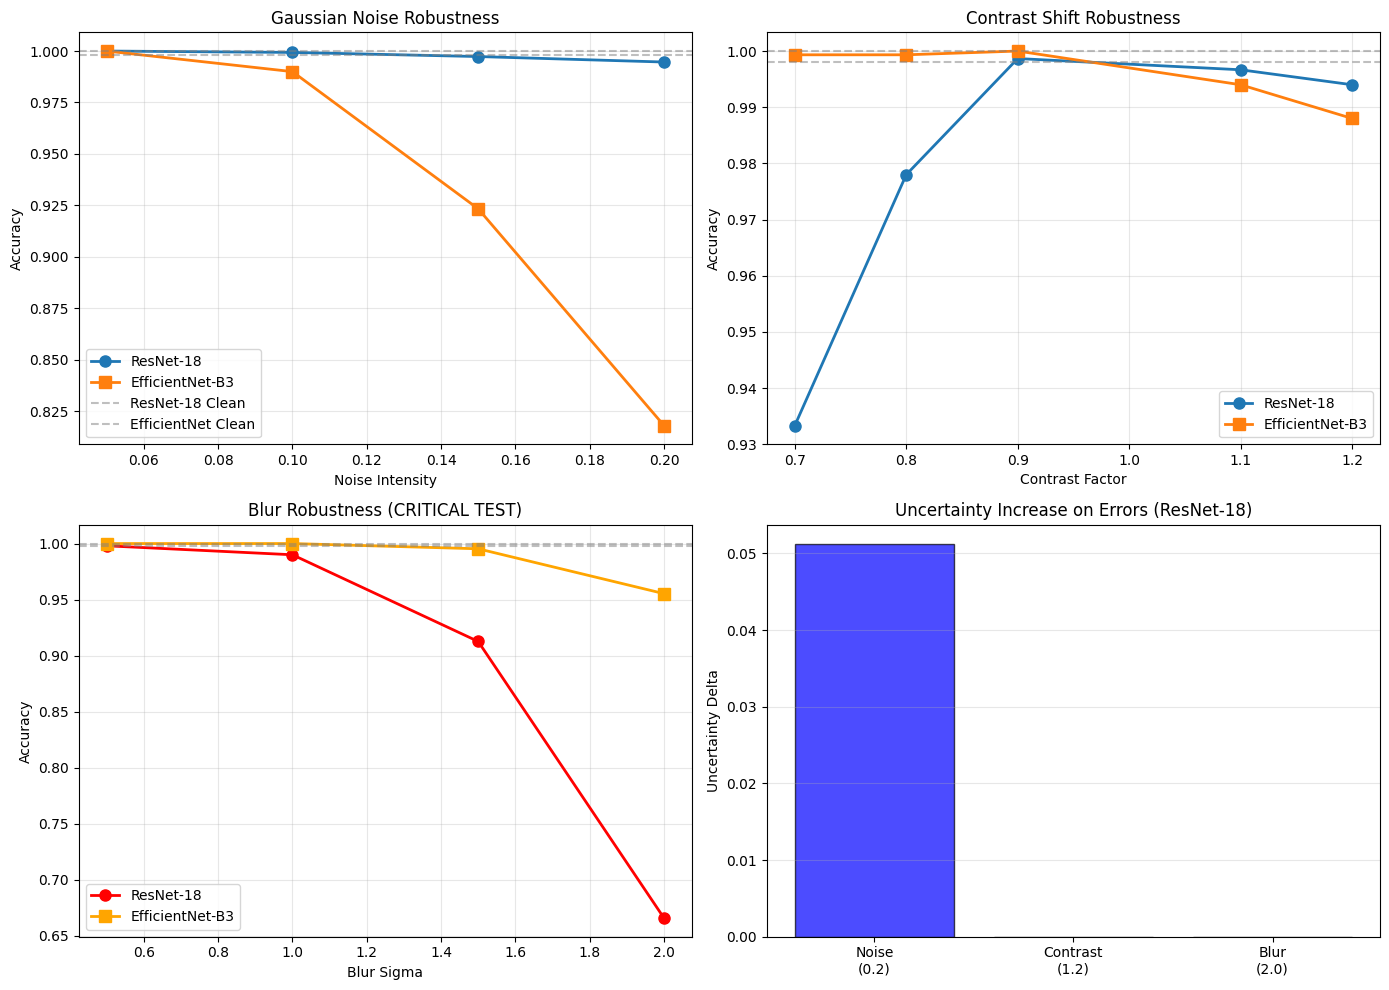


Visualization saved to results/robust_models_robustness_comparison.png


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import os
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# 1. DATASET


class KidneyDataset(Dataset):
    def __init__(self, labels_list, data_dir, transform=None):
        self.labels_list = labels_list
        self.data_dir = data_dir
        self.transform = transform
        self.label_to_idx = {'kidney_normal': 0, 'kidney_tumor': 1}
    
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, idx):
        item = self.labels_list[idx]
        img_path = os.path.join(self.data_dir, item['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[item['label']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load data
with open('data/test_labels.json', 'r') as f:
    test_labels = json.load(f)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

test_dataset = KidneyDataset(test_labels, 'data/test', val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print("Dataset loaded!")


# 2. PERTURBATION FUNCTIONS


def add_gaussian_noise(image, intensity):
    """Add Gaussian noise to image tensor"""
    noise = torch.randn_like(image) * intensity
    return torch.clamp(image + noise, -2.1, 2.8)

def contrast_shift(image, factor):
    """Simulate different CT contrast settings"""
    image = image * factor
    return torch.clamp(image, -2.1, 2.8)

def apply_blur(image, sigma):
    """Apply Gaussian blur"""
    image_np = image.permute(1, 2, 0).numpy()
    blurred = np.stack([gaussian_filter(image_np[:,:,i], sigma=sigma) 
                       for i in range(image_np.shape[2])], axis=2)
    return torch.from_numpy(blurred).permute(2, 0, 1).float()


# 3. MC DROPOUT WITH PERTURBATIONS


def get_mc_dropout_predictions_perturbed(model, loader, device, perturbation_fn, 
                                        perturbation_params, n_samples=20):
    """MC Dropout predictions with image perturbations"""
    all_probs_samples = []
    all_labels = []
    
    # Enable dropout
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()
    
    with torch.no_grad():
        for images, labels in loader:
            batch_samples = []
            
            for _ in range(n_samples):
                # Apply perturbation
                perturbed_images = torch.stack([
                    perturbation_fn(images[i], **perturbation_params) 
                    for i in range(images.shape[0])
                ])
                perturbed_images = perturbed_images.to(device)
                
                outputs = model(perturbed_images)
                probs = F.softmax(outputs, dim=1)
                batch_samples.append(probs.cpu().numpy())
            
            all_probs_samples.append(np.array(batch_samples))
            all_labels.extend(labels.numpy())
    
    all_probs_samples = np.concatenate(all_probs_samples, axis=1)
    all_labels = np.array(all_labels)
    
    mean_probs = all_probs_samples.mean(axis=0)
    std_probs = all_probs_samples.std(axis=0)
    
    preds = np.argmax(mean_probs, axis=1)
    uncertainty = std_probs[:, 1]
    confidence = np.max(mean_probs, axis=1)
    
    return preds, mean_probs, confidence, uncertainty, all_labels


# 4. LOAD ROBUST MODELS



print("LOADING ROBUST MODELS")


# Load Robust ResNet-18
model_resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_resnet.fc = nn.Linear(512, 2)
model_resnet.load_state_dict(torch.load('checkpoints/robust_resnet18_best.pth'))
model_resnet = model_resnet.to(device)
model_resnet.eval()
print("✓ Robust ResNet-18 loaded")

# Load Robust EfficientNet-B3
model_efficient = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
model_efficient.classifier[1] = nn.Linear(1536, 2)
model_efficient.load_state_dict(torch.load('checkpoints/robust_efficientnet_b3_best.pth'))
model_efficient = model_efficient.to(device)
model_efficient.eval()
print("✓ Robust EfficientNet-B3 loaded")


# 5. TEST ON CLEAN BASELINE


print("BASELINE: CLEAN IMAGES")


def evaluate_clean(model, loader, device, model_name):
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model, loader, device, lambda x, **kwargs: x, {}, n_samples=20
    )
    
    acc = accuracy_score(labels, preds)
    print(f"{model_name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Mean Confidence: {conf.mean():.6f}")
    print(f"  Mean Uncertainty: {unc.mean():.6f}")
    
    return preds, probs, conf, unc, labels, acc

resnet_clean_preds, resnet_clean_probs, resnet_clean_conf, resnet_clean_unc, resnet_clean_labels, resnet_clean_acc = evaluate_clean(
    model_resnet, test_loader, device, "Robust ResNet-18"
)

efficient_clean_preds, efficient_clean_probs, efficient_clean_conf, efficient_clean_unc, efficient_clean_labels, efficient_clean_acc = evaluate_clean(
    model_efficient, test_loader, device, "Robust EfficientNet-B3"
)


# 6. TEST UNDER PERTURBATIONS


results_comparison = {
    'resnet18': {'clean': resnet_clean_acc},
    'efficientnet_b3': {'clean': efficient_clean_acc}
}

# GAUSSIAN NOISE

print("PERTURBATION 1: GAUSSIAN NOISE")


noise_intensities = [0.05, 0.1, 0.15, 0.2]

print("\nRobust ResNet-18:")
for intensity in noise_intensities:
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model_resnet, test_loader, device, add_gaussian_noise, 
        {'intensity': intensity}, n_samples=20
    )
    acc = accuracy_score(labels, preds)
    errors = (preds != labels).astype(int)
    unc_on_errors = unc[errors == 1].mean() if errors.sum() > 0 else 0
    unc_on_correct = unc[errors == 0].mean()
    
    print(f"  Intensity {intensity}: Acc={acc:.4f}, Unc_Delta={unc_on_errors - unc_on_correct:.6f}")
    results_comparison['resnet18'][f'noise_{intensity}'] = {
        'accuracy': acc,
        'uncertainty_delta': unc_on_errors - unc_on_correct
    }

print("\nRobust EfficientNet-B3:")
for intensity in noise_intensities:
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model_efficient, test_loader, device, add_gaussian_noise, 
        {'intensity': intensity}, n_samples=20
    )
    acc = accuracy_score(labels, preds)
    errors = (preds != labels).astype(int)
    unc_on_errors = unc[errors == 1].mean() if errors.sum() > 0 else 0
    unc_on_correct = unc[errors == 0].mean()
    
    print(f"  Intensity {intensity}: Acc={acc:.4f}, Unc_Delta={unc_on_errors - unc_on_correct:.6f}")
    results_comparison['efficientnet_b3'][f'noise_{intensity}'] = {
        'accuracy': acc,
        'uncertainty_delta': unc_on_errors - unc_on_correct
    }

# CONTRAST SHIFT

print("PERTURBATION 2: CONTRAST SHIFT")


contrast_factors = [0.7, 0.8, 0.9, 1.1, 1.2]

print("\nRobust ResNet-18:")
for factor in contrast_factors:
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model_resnet, test_loader, device, contrast_shift, 
        {'factor': factor}, n_samples=20
    )
    acc = accuracy_score(labels, preds)
    errors = (preds != labels).astype(int)
    unc_on_errors = unc[errors == 1].mean() if errors.sum() > 0 else 0
    unc_on_correct = unc[errors == 0].mean()
    
    print(f"  Factor {factor}: Acc={acc:.4f}, Unc_Delta={unc_on_errors - unc_on_correct:.6f}")
    results_comparison['resnet18'][f'contrast_{factor}'] = {
        'accuracy': acc,
        'uncertainty_delta': unc_on_errors - unc_on_correct
    }

print("\nRobust EfficientNet-B3:")
for factor in contrast_factors:
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model_efficient, test_loader, device, contrast_shift, 
        {'factor': factor}, n_samples=20
    )
    acc = accuracy_score(labels, preds)
    errors = (preds != labels).astype(int)
    unc_on_errors = unc[errors == 1].mean() if errors.sum() > 0 else 0
    unc_on_correct = unc[errors == 0].mean()
    
    print(f"  Factor {factor}: Acc={acc:.4f}, Unc_Delta={unc_on_errors - unc_on_correct:.6f}")
    results_comparison['efficientnet_b3'][f'contrast_{factor}'] = {
        'accuracy': acc,
        'uncertainty_delta': unc_on_errors - unc_on_correct
    }

# BLUR - THE CRITICAL TEST

print("PERTURBATION 3: BLUR (CRITICAL TEST)")


blur_sigmas = [0.5, 1.0, 1.5, 2.0]

print("\nRobust ResNet-18:")
for sigma in blur_sigmas:
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model_resnet, test_loader, device, apply_blur, 
        {'sigma': sigma}, n_samples=20
    )
    acc = accuracy_score(labels, preds)
    acc_drop = resnet_clean_acc - acc
    errors = (preds != labels).astype(int)
    unc_on_errors = unc[errors == 1].mean() if errors.sum() > 0 else 0
    unc_on_correct = unc[errors == 0].mean()
    
    print(f"  Sigma {sigma}: Acc={acc:.4f}, Drop={acc_drop:.4f}, Unc_Delta={unc_on_errors - unc_on_correct:.6f}")
    results_comparison['resnet18'][f'blur_{sigma}'] = {
        'accuracy': acc,
        'accuracy_drop': acc_drop,
        'uncertainty_delta': unc_on_errors - unc_on_correct
    }

print("\nRobust EfficientNet-B3:")
for sigma in blur_sigmas:
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model_efficient, test_loader, device, apply_blur, 
        {'sigma': sigma}, n_samples=20
    )
    acc = accuracy_score(labels, preds)
    acc_drop = efficient_clean_acc - acc
    errors = (preds != labels).astype(int)
    unc_on_errors = unc[errors == 1].mean() if errors.sum() > 0 else 0
    unc_on_correct = unc[errors == 0].mean()
    
    print(f"  Sigma {sigma}: Acc={acc:.4f}, Drop={acc_drop:.4f}, Unc_Delta={unc_on_errors - unc_on_correct:.6f}")
    results_comparison['efficientnet_b3'][f'blur_{sigma}'] = {
        'accuracy': acc,
        'accuracy_drop': acc_drop,
        'uncertainty_delta': unc_on_errors - unc_on_correct
    }


# 7. SAVE RESULTS


def convert_to_serializable(obj):
    if isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj

results_serializable = convert_to_serializable(results_comparison)

with open('results/robust_models_comparison.json', 'w') as f:
    json.dump(results_serializable, f, indent=2)


print("Results saved to results/robust_models_comparison.json")



# 8. VISUALIZATION


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Noise robustness comparison
ax = axes[0, 0]
noise_accs_resnet = [results_comparison['resnet18'][f'noise_{i}']['accuracy'] for i in noise_intensities]
noise_accs_efficient = [results_comparison['efficientnet_b3'][f'noise_{i}']['accuracy'] for i in noise_intensities]

ax.plot(noise_intensities, noise_accs_resnet, 'o-', label='ResNet-18', linewidth=2, markersize=8)
ax.plot(noise_intensities, noise_accs_efficient, 's-', label='EfficientNet-B3', linewidth=2, markersize=8)
ax.axhline(y=resnet_clean_acc, color='gray', linestyle='--', alpha=0.5, label='ResNet-18 Clean')
ax.axhline(y=efficient_clean_acc, color='gray', linestyle='--', alpha=0.5, label='EfficientNet Clean')
ax.set_xlabel('Noise Intensity')
ax.set_ylabel('Accuracy')
ax.set_title('Gaussian Noise Robustness')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Contrast shift robustness
ax = axes[0, 1]
contrast_accs_resnet = [results_comparison['resnet18'][f'contrast_{f}']['accuracy'] for f in contrast_factors]
contrast_accs_efficient = [results_comparison['efficientnet_b3'][f'contrast_{f}']['accuracy'] for f in contrast_factors]

ax.plot(contrast_factors, contrast_accs_resnet, 'o-', label='ResNet-18', linewidth=2, markersize=8)
ax.plot(contrast_factors, contrast_accs_efficient, 's-', label='EfficientNet-B3', linewidth=2, markersize=8)
ax.axhline(y=resnet_clean_acc, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=efficient_clean_acc, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Contrast Factor')
ax.set_ylabel('Accuracy')
ax.set_title('Contrast Shift Robustness')
ax.legend()
ax.grid(alpha=0.3)

# Plot 3: Blur robustness (THE CRITICAL TEST)
ax = axes[1, 0]
blur_accs_resnet = [results_comparison['resnet18'][f'blur_{s}']['accuracy'] for s in blur_sigmas]
blur_accs_efficient = [results_comparison['efficientnet_b3'][f'blur_{s}']['accuracy'] for s in blur_sigmas]

ax.plot(blur_sigmas, blur_accs_resnet, 'o-', color='red', label='ResNet-18', linewidth=2, markersize=8)
ax.plot(blur_sigmas, blur_accs_efficient, 's-', color='orange', label='EfficientNet-B3', linewidth=2, markersize=8)
ax.axhline(y=resnet_clean_acc, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=efficient_clean_acc, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Blur Sigma')
ax.set_ylabel('Accuracy')
ax.set_title('Blur Robustness (CRITICAL TEST)')
ax.legend()
ax.grid(alpha=0.3)

# Plot 4: Uncertainty Delta across perturbations
ax = axes[1, 1]
noise_deltas_resnet = [results_comparison['resnet18'][f'noise_{i}'].get('uncertainty_delta', 0) for i in noise_intensities]
blur_deltas_resnet = [results_comparison['resnet18'][f'blur_{s}'].get('uncertainty_delta', 0) for s in blur_sigmas]

categories = ['Noise\n(0.2)', 'Contrast\n(1.2)', 'Blur\n(2.0)']
deltas = [
    np.mean([results_comparison['resnet18'][f'noise_{i}'].get('uncertainty_delta', 0) for i in noise_intensities]),
    np.mean([results_comparison['resnet18'][f'contrast_{f}'].get('uncertainty_delta', 0) for f in contrast_factors]),
    results_comparison['resnet18'][f'blur_{blur_sigmas[-1]}'].get('uncertainty_delta', 0)
]

ax.bar(categories, deltas, color=['blue', 'orange', 'red'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Uncertainty Delta')
ax.set_title('Uncertainty Increase on Errors (ResNet-18)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/robust_models_robustness_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to results/robust_models_robustness_comparison.png")
